In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm

from swarm_sim import *

%matplotlib inline 

In [16]:
NB_NODES = 50
REVOLUTION = 1800 # Number of data rows
CONNECTION_RANGE = 30 # km
SAMPLE_STEP = 12
NB_REPETITIONS = 30

## 1. Analyse du degré moyen

In [39]:
df_rnd = pd.read_csv('..\output\data\sat50_RMSE_RND_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_mirw = pd.read_csv('..\output\data\sat50_RMSE_MIRW_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_ffd = pd.read_csv('..\output\data\sat50_RMSE_FFD_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')

df_rnd = df_rnd.groupby('Nb groups').mean()
df_mirw = df_mirw.groupby('Nb groups').mean()
df_ffd = df_ffd.groupby('Nb groups').mean()

In [40]:
df_mirw.head()

,Timestamp,RMSE AD,RMSE ACC
Nb groups,,,
1,894.0,0.000000,8.551184e-17
2,894.0,2.210178,3.836971e-02
3,894.0,2.669514,6.049052e-02
4,894.0,3.142866,7.334696e-02
5,894.0,3.185426,8.475906e-02


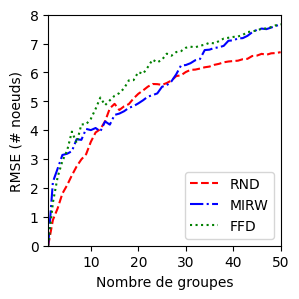

In [41]:
plt.figure(figsize=(3,3))
idx = np.arange(1, NB_NODES+1)
#idx_scat = np.arange(1, NB_NODES+1, 5)

col = 'RMSE AD' 
plt.plot(idx, df_rnd[col], '--r', label='RND')
plt.plot(idx, df_mirw[col], '-.b', label='MIRW')
plt.plot(idx, df_ffd[col], ':g', label='FFD')

#plt.plot(idx, df_rnd[col], marker='x', markevery=idx_scat, label='RND')
#plt.plot(idx, df_mirw[col], marker='o', markevery=idx_scat, label='MIRW')
#plt.plot(idx, df_ffd[col], marker='d', markevery=idx_scat, label='FFD')

plt.xlabel('Nombre de groupes')
plt.ylabel('RMSE (# noeuds)')
plt.xlim(1,50)
plt.ylim(0,8)
plt.legend()

## 2. Analyse de la taille des groupes

In [21]:
PATH = '..\\..\\data\\swarm-50-sats-scenario\\coords_v1_if_LLO-'
ROW_DATA = 7

In [23]:
def rmse(data, ref=None): # Compare the observed distribution to a reference value
    if ref == None:
        ref = np.mean(data)
    errors = [(e-ref)**2 for e in data]
    ratio = sum(errors)/len(data)
    return np.sqrt(ratio)

In [22]:
satellites = {} # Dict(sat_id: DataFrame)
with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df_data = pd.read_csv(PATH+str(i)+'.csv', skiprows= lambda x: x<ROW_DATA, header=0)
        satellites[i] = df_data
        pbar.update(1)
        
swarm_data = {} # Dict{timestamp: Swarm}
with tqdm(total=REVOLUTION, desc='Converting to topologies') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(CONNECTION_RANGE,
                    nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                    )
        pbar.update(1)

neighbor_matrices = {} # Dict{timestamp: matrix}
with tqdm(total=REVOLUTION, desc='Computing neighbor matrices') as pbar:
    for t in range(REVOLUTION):
        neighbor_matrices[t] = swarm_data[t].neighbor_matrix()
        pbar.update(1)

topo_graphs = {} # Dict{timestamp: Graph}
with tqdm(total=REVOLUTION, desc='Converting to NetworkX graphs') as pbar:
    for t in range(REVOLUTION):
        topo_graphs[t] = swarm_data[t].swarm_to_nxgraph()
        pbar.update(1)

Converting to NetworkX graphs: 100%|██████████| 1800/1800 [00:03<00:00, 482.10it/s]


In [24]:
nb_groups = np.arange(1,NB_NODES+1)
rmse_rnd = []
rmse_mirw = []
rmse_ffd = []

for nb in nb_groups:
    ref_ns = NB_NODES/nb
    #print('Testing RND')
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].RND(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    rmse_rnd.append(rmse(ns, ref_ns))
    #print('Testing MIRW')
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].MIRW(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    rmse_mirw.append(rmse(ns, ref_ns))
    #print('Testing FFD')
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].FFD(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    rmse_ffd.append(rmse(ns, ref_ns))

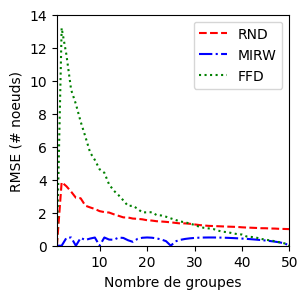

In [37]:
plt.figure(figsize=(3,3))
idx_scat = np.arange(1, NB_NODES+1, 5)

plt.plot(nb_groups, rmse_rnd, '--r', label='RND')
plt.plot(nb_groups, rmse_mirw, '-.b', label='MIRW')
plt.plot(nb_groups, rmse_ffd, ':g', label='FFD')
plt.xlabel('Nombre de groupes')
plt.ylabel('RMSE (# noeuds)')
plt.xlim(1,50)
plt.ylim(0,14)
plt.legend()

## 3. Analyse du coût de routage

In [26]:
df_rnd = pd.read_csv('..\output\data\sat50_RCOST_RND_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_mirw = pd.read_csv('..\output\data\sat50_RCOST_MIRW_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_ffd = pd.read_csv('..\output\data\sat50_RCOST_FFD_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')

df_rnd = df_rnd.groupby('Nb groups').mean()
df_mirw = df_mirw.groupby('Nb groups').mean()
df_ffd = df_ffd.groupby('Nb groups').mean()

In [27]:
df_mirw.head()

,Timestamp,Rcost
Nb groups,,
1,894.0,5283.240000
2,894.0,2562.399556
3,894.0,1657.268000
4,894.0,1205.074667
5,894.0,933.115111


In [28]:
ref_rcost_avg = 5283.24

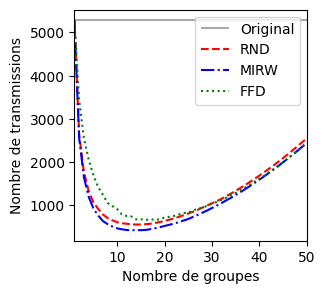

In [38]:
plt.figure(figsize=(3,3))
idx = np.arange(1, NB_NODES+1)

col = 'Rcost' 
plt.hlines(ref_rcost_avg, xmin=1, xmax=50, colors='darkgray', label='Original')
plt.plot(idx, df_rnd[col], '--r', label='RND')
plt.plot(idx, df_mirw[col], '-.b', label='MIRW')
plt.plot(idx, df_ffd[col], ':g', label='FFD')

plt.xlabel('Nombre de groupes')
plt.ylabel('Nombre de transmissions')
plt.xlim(1,50)
#plt.ylim(0,30)
plt.legend()